In [1]:
from typing import Dict, Any
import pathlib

from utils import dnde_positron, make_processes, process_string_to_latex, DecayProcess
from utils import electron
from utils import muon
from utils import charged_pion
from utils import charged_kaon
from utils import short_kaon
from utils import long_kaon
from utils import eta
from utils import charged_rho
from utils import eta_prime
from utils import omega
from utils import phi

from hazma import spectra
from hazma import parameters
from hazma.spectra.boost import boost_delta_function

# from hazma.decay import long_kaon as long_kaon_decay
#from hazma.decay import short_kaon as short_kaon_decay

import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
me = electron.mass

def boost_energy(e, gamma):
    beta = np.sqrt(1.0 - gamma**-2)
    return gamma * (e + beta * np.sqrt(e**2 - me**2))

EMAX_MU_RF = (muon.mass**2 + electron.mass**2) / (2.0 * muon.mass)
EMU_PI_RF = (charged_pion.mass**2 + muon.mass**2) / (2.0 * charged_pion.mass)

EMAX_PI_RF = boost_energy(EMAX_MU_RF, EMU_PI_RF / muon.mass)

In [3]:
THIS_DIR = pathlib.Path(".").absolute()
DATA_DIR = THIS_DIR.joinpath("data")

In [4]:
qualitative = [
        "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#a65628",
    "#f781bf",
    "#999999",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]

In [5]:
from charged_kaon import processes as charged_kaon_processes
from long_kaon import processes as long_kaon_processes
from short_kaon import processes as short_kaon_processes
from eta import processes as eta_processes
from eta_prime import processes as eta_prime_processes
from omega import processes as omega_processes
from phi import processes as phi_processes

In [6]:
def make_spectrum_plot(energies, dndes: Dict[str, Any]):
    params = {key: dict(color=qualitative[i], linewidth=1, label=process_string_to_latex(key)) for i, key in enumerate(dndes.keys())}
    params["total"] = dict(color="k", linewidth=2, alpha=0.6, label=r"$\mathrm{Total}$")

    plt.figure(dpi=150)
    for key, val in dndes.items():
        plt.plot(energies, val, **params[key])
    plt.plot(energies, sum(dndes.values()), **params["total"])
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-7, 1)
    plt.xlim(np.min(es), np.max(es))
    plt.legend()

0.9996642360525902


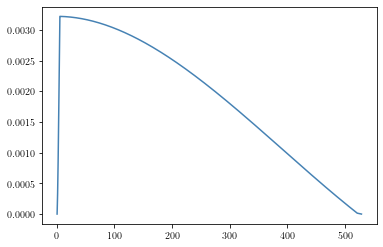

In [7]:
me = parameters.electron_mass
mmu = parameters.muon_mass
emu = 5 * mmu
es = np.geomspace(me, emu, 500)
dndes= spectra.dnde_positron_muon(es, emu)

print(np.trapz(dndes, es))

plt.plot(es, dndes)

In [8]:
me = parameters.electron_mass
mpi = parameters.charged_pion_mass
epi = 10 * mpi
es = np.geomspace(me, epi, 500)
dndes= spectra.dnde_positron_charged_pion(es, epi)

np.trapz(dndes, es)

0.9996643078433948

## $\mu^{\pm}$

## $K^{\pm}$

In [9]:
charged_kaon_procs = make_processes(charged_kaon, charged_kaon_processes, nbins=100)

In [10]:
pi0_e_nu = DecayProcess(
    parent=charged_kaon,
    branching_fraction=charged_kaon_procs.processes["pi0 e nu"].branching_fraction,
    final_states=charged_kaon_procs.processes["pi0 e nu"].final_states,
    msqrd=charged_kaon_procs.processes["pi0 e nu"].msqrd,
    nbins=200,
)

246.83876446433894


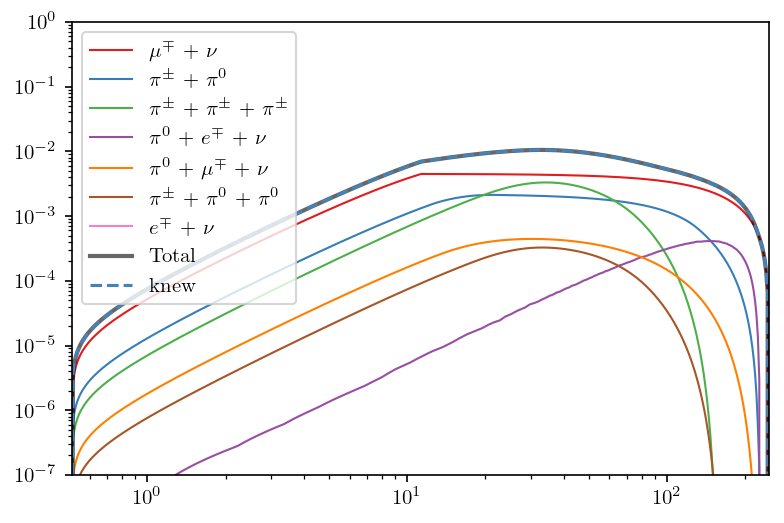

In [11]:
me = electron.mass
mmu = muon.mass
mk = charged_kaon.mass

emu_k_rf = 0.5 * (mk**2 + mmu**2) / mk
emax_k_rf = boost_energy(EMAX_MU_RF, emu_k_rf / mmu)
print(emax_k_rf)


es = np.geomspace(electron.mass * (1 + 2**(-50)), emax_k_rf, 500)
dnde = dnde_positron(es, charged_kaon_procs)

x, y = pi0_e_nu.energy_distributions[1]
dnde["pi0 e nu"] += pi0_e_nu.branching_fraction * interpolate.InterpolatedUnivariateSpline(x, y, ext=1, k=1)(es)

make_spectrum_plot(es, dnde)
#plt.vlines(emax_k_rf, 1e-7, 1.0)
plt.plot(es, spectra.dnde_positron_charged_kaon(es, parameters.charged_kaon_mass), label="knew", ls="--")
# plt.ylim(1e-7, 1e5)
plt.legend()

In [12]:
# Check normalization
np.trapz(sum(dnde.values()), es)

1.1108767476434573

In [13]:
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es,*dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("charged_kaon_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

## $K_{S}$

In [14]:
short_kaon_procs = make_processes(short_kaon, short_kaon_processes)

227.38881652325836


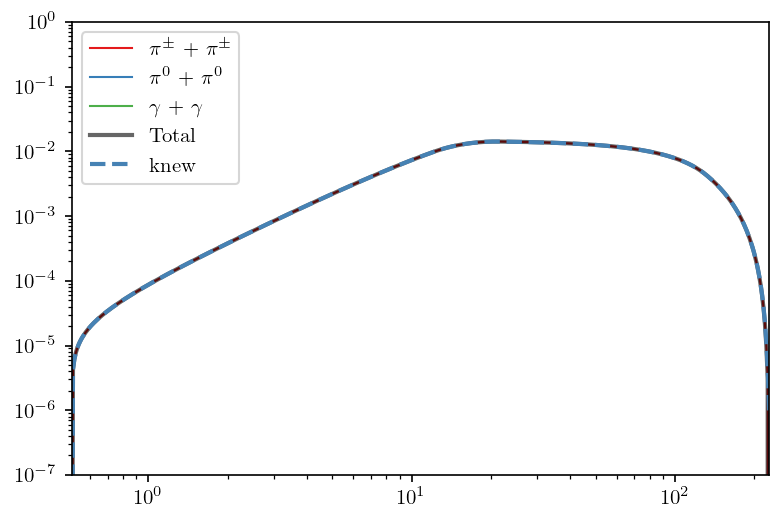

In [15]:
me = electron.mass
mpi = charged_pion.mass
mk = short_kaon.mass

gamma = 0.5 * (mk**2) / (mk * mpi)
emax_k_rf = boost_energy(EMAX_PI_RF, gamma)
print(emax_k_rf)


es = np.geomspace(electron.mass * (1.0 + 2**(-50)), emax_k_rf, 500)
dnde = dnde_positron(es, short_kaon_procs)
make_spectrum_plot(es, dnde)
plt.plot(es, spectra.dnde_positron_short_kaon(es, parameters.short_kaon_mass*1.0001), label="knew", lw=2, ls='--')
plt.legend()

In [266]:
del dnde["a a"]
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es,*dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("short_kaon_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

## $K_{L}$

In [16]:
long_kaon_procs = make_processes(long_kaon, long_kaon_processes)

In [17]:
pi_e_nu = DecayProcess(
    parent=long_kaon,
    branching_fraction=long_kaon_procs.processes["pi e nu"].branching_fraction,
    msqrd=long_kaon_procs.processes["pi e nu"].msqrd,
    final_states=long_kaon_procs.processes["pi e nu"].final_states,
    nbins=300,
)

248.80576237354376


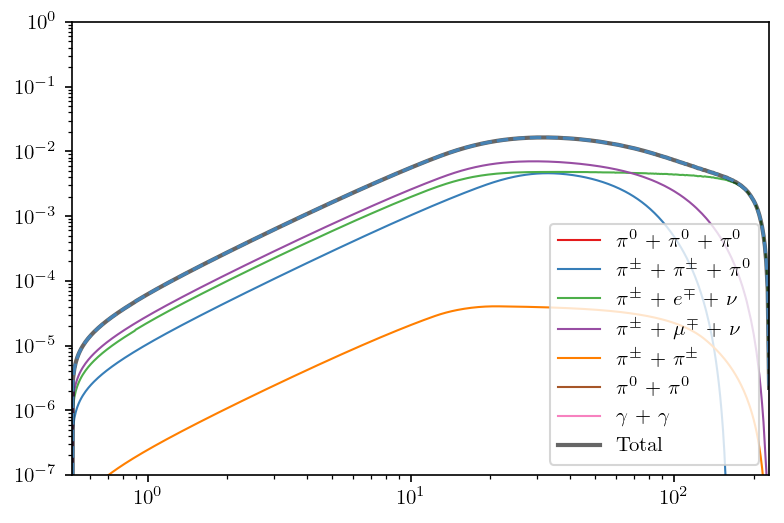

In [18]:
me = electron.mass
mmu = muon.mass
mk = long_kaon.mass

emu_k_rf = 0.5 * (mk**2 + mmu**2) / mk

gamma_mu = emu_k_rf / mmu
beta_mu = np.sqrt(1.0 - gamma_mu**-2)

emax_mu_rf = (me**2 + mmu**2) / (2 * mmu)
emax_k_rf = gamma_mu * emax_mu_rf * (1 + beta_mu * np.sqrt(1 - (me/emax_mu_rf)**2))
print(emax_k_rf)

emax = (mk**2 + me**2 - mpi**2) / (2 * mk)
es = np.geomspace(electron.mass * (1.0 + 2**(-50)), emax, 500)
dnde = dnde_positron(es, long_kaon_procs)

x, y = pi_e_nu.energy_distributions[1]
dnde["pi e nu"] += pi_e_nu.branching_fraction * interpolate.InterpolatedUnivariateSpline(x, y, ext=1, k=1)(es)

make_spectrum_plot(es, dnde)
plt.plot(es, spectra.dnde_positron_long_kaon(es, long_kaon_procs.parent.mass), label="built-in", ls="--")
# plt.ylim(1e-7, 1e5)
# plt.legend()

In [269]:
del dnde["a a"]
del dnde["pi0 pi0"]
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es,*dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("long_kaon_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

In [270]:

print(np.trapz(sum(dnde.values()), es))

(2 * long_kaon_procs.processes["pi pi pi0"].branching_fraction
+2 * long_kaon_procs.processes["pi e nu"].branching_fraction
+2 * long_kaon_procs.processes["pi mu nu"].branching_fraction
+2 * long_kaon_procs.processes["pi pi"].branching_fraction)

1.5782733336350692


1.6065340000000001

## $\eta$

In [19]:
eta_procs = make_processes(eta, eta_processes)

263.3327735222255


(1e-09, 1)

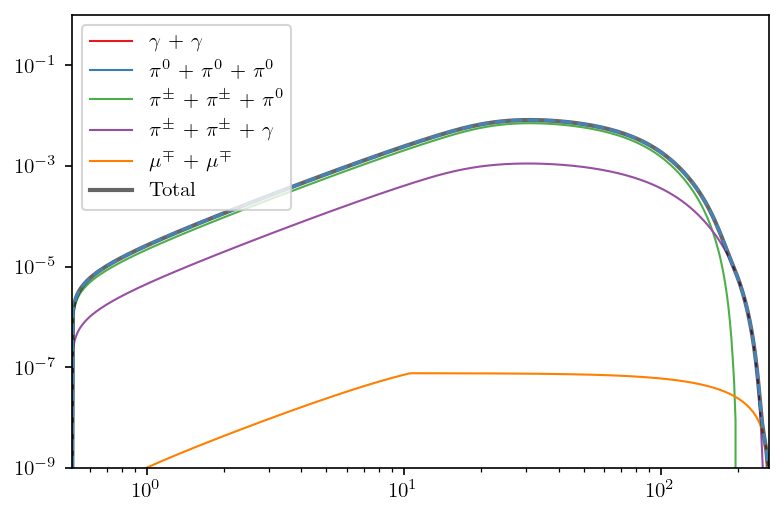

In [20]:
me = electron.mass
mmu = muon.mass
mpi = charged_pion.mass
meta = eta.mass


gamma = meta / (2 * mmu)
emax = boost_energy(EMAX_MU_RF, gamma)

print(emax)


es = np.geomspace(electron.mass * (1.0 + 2**(-50)), emax, 500)
dnde = dnde_positron(es, eta_procs)
make_spectrum_plot(es, dnde)
plt.plot(es, spectra.dnde_positron_eta(es, eta_procs.parent.mass), label="knew", ls="--")
plt.ylim(1e-9, 1)
# plt.legend()


In [276]:
del dnde["a a"]
del dnde["pi0 pi0 pi0"]
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es,*dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("eta_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

In [278]:
np.trapz(sum(dnde.values()), x=es)

0.5346486919258004

## $\omega$

In [9]:
omega_procs = make_processes(omega, omega_processes)

In [10]:
me = electron.mass
mmu = muon.mass
mpi = charged_pion.mass
mw = omega.mass

gamma = mw / (2 * mpi)
emax = boost_energy(EMAX_PI_RF, gamma)
print(emax)

378.46237920519985


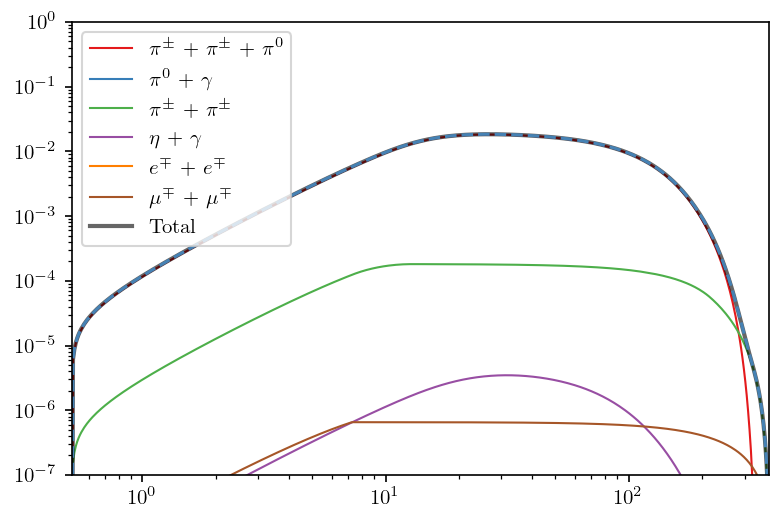

In [11]:
es = np.geomspace(electron.mass * (1.0 + 2**(-50)), emax, 500)
dnde = dnde_positron(es, omega_procs)
make_spectrum_plot(es, dnde)
plt.plot(es, spectra.dnde_positron_omega(es, omega.mass), label="builtin", ls="--")

In [18]:
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es, *dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("omega_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

## $\rho$

In [20]:
me = electron.mass
mmu = muon.mass
mpi = charged_pion.mass
mrho = charged_rho.mass

gamma = mrho / (2 * mpi)
emax = boost_energy(EMAX_PI_RF, gamma)
print(emax)

374.6307730914443


(0.5109989461000004, 374.6307730914443)

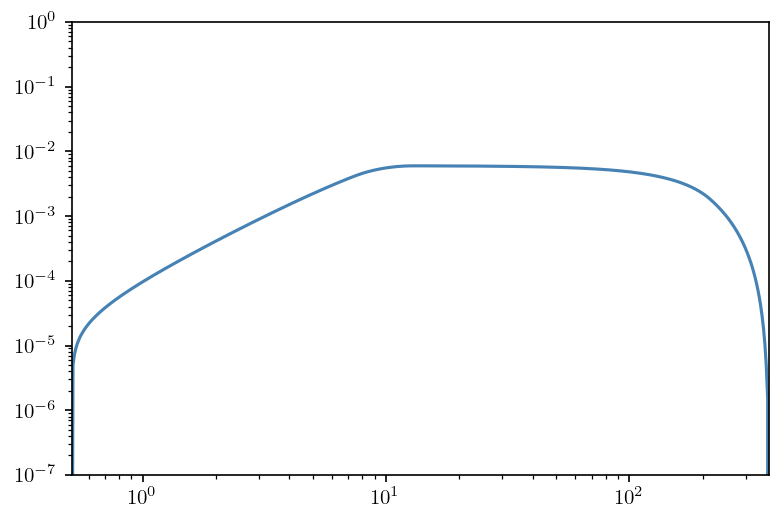

In [21]:
es = np.geomspace(electron.mass * (1.0 + 2**(-50)), emax, 500)
dnde = spectra.dnde_positron_charged_pion(es, mrho / 2)

plt.figure(dpi=150)
plt.plot(es, dnde)
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-7, 1)
plt.xlim(es.min(), es.max())

In [22]:
header = "energy," + "dnde"
data = np.array([es, dnde]).T
np.savetxt(
    DATA_DIR.joinpath("rho_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

## $\eta'$

In [9]:
eta_prime_procs = make_processes(eta_prime, eta_prime_processes)

In [11]:
me = electron.mass
mmu = muon.mass
mpi = charged_pion.mass
mrho = charged_rho.mass
metap = eta_prime.mass

gamma = mrho / (2 * mpi)
emax_rho_rf = boost_energy(EMAX_PI_RF, gamma)

gamma = (metap**2 + mrho**2) / (2 * metap * mrho)
emax = boost_energy(emax_rho_rf, gamma)

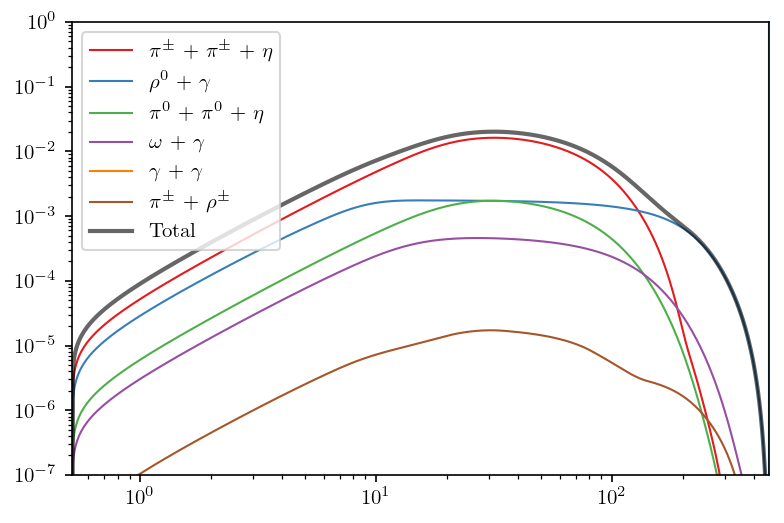

In [14]:
es = np.geomspace(me * (1 + 2**(-50)), emax, 500)
dnde = dnde_positron(es, eta_prime_procs)
make_spectrum_plot(es, dnde)
plt.vlines(emax, 1e-7, 1)
#plt.plot(es, spectra.dnde_photon_eta_prime(es, eta_prime.mass),ls="--")

In [15]:
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es, *dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("eta_prime_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)

## $\phi$

In [9]:
phi_procs = make_processes(phi, phi_processes)

In [11]:
me = electron.mass
mmu = muon.mass
mphi = phi.mass

gamma = mphi / (2 * mmu)
emax = boost_energy(EMAX_MU_RF, gamma)

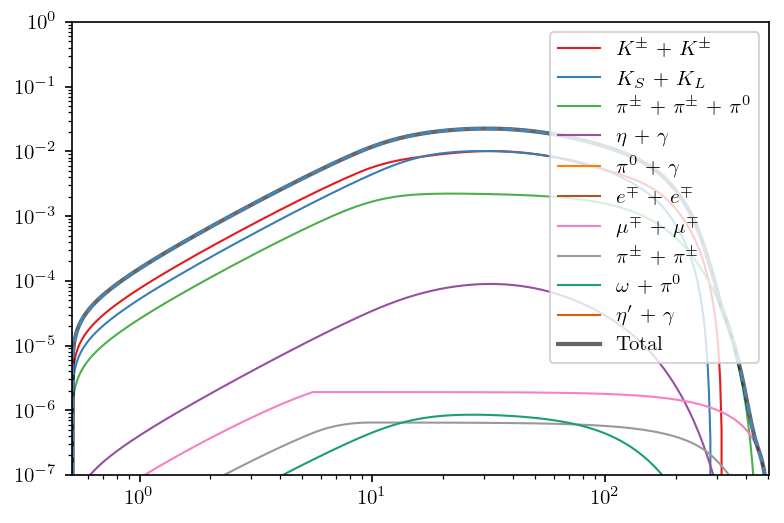

In [13]:
es = np.geomspace(me * (1 + 2**(-50)), emax, 500)
dnde = dnde_positron(es, phi_procs)
make_spectrum_plot(es, dnde)
plt.plot(es, spectra.dnde_positron_phi(es, phi.mass), ls="--")
# plt.legend(loc=0, bbox_to_anchor=(1.05, 0.9))

In [23]:
header = "energy," + ",".join(list(map(lambda string: "_".join(string.split(" ")), dnde.keys())))
data = np.array([es, *dnde.values()]).T
np.savetxt(
    DATA_DIR.joinpath("phi_positron.csv"), 
    data, 
    fmt="%.15e", 
    delimiter=",", 
    header=header,
)